<a href="https://colab.research.google.com/github/singhsukhendra/Breast-Cancer-Coimbra-Data-Set-/blob/master/CNN_on_IDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/NMADALI97/Histopathologic-Breast-Cancer-Detection.git

Cloning into 'Histopathologic-Breast-Cancer-Detection'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 11), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (32/32), done.


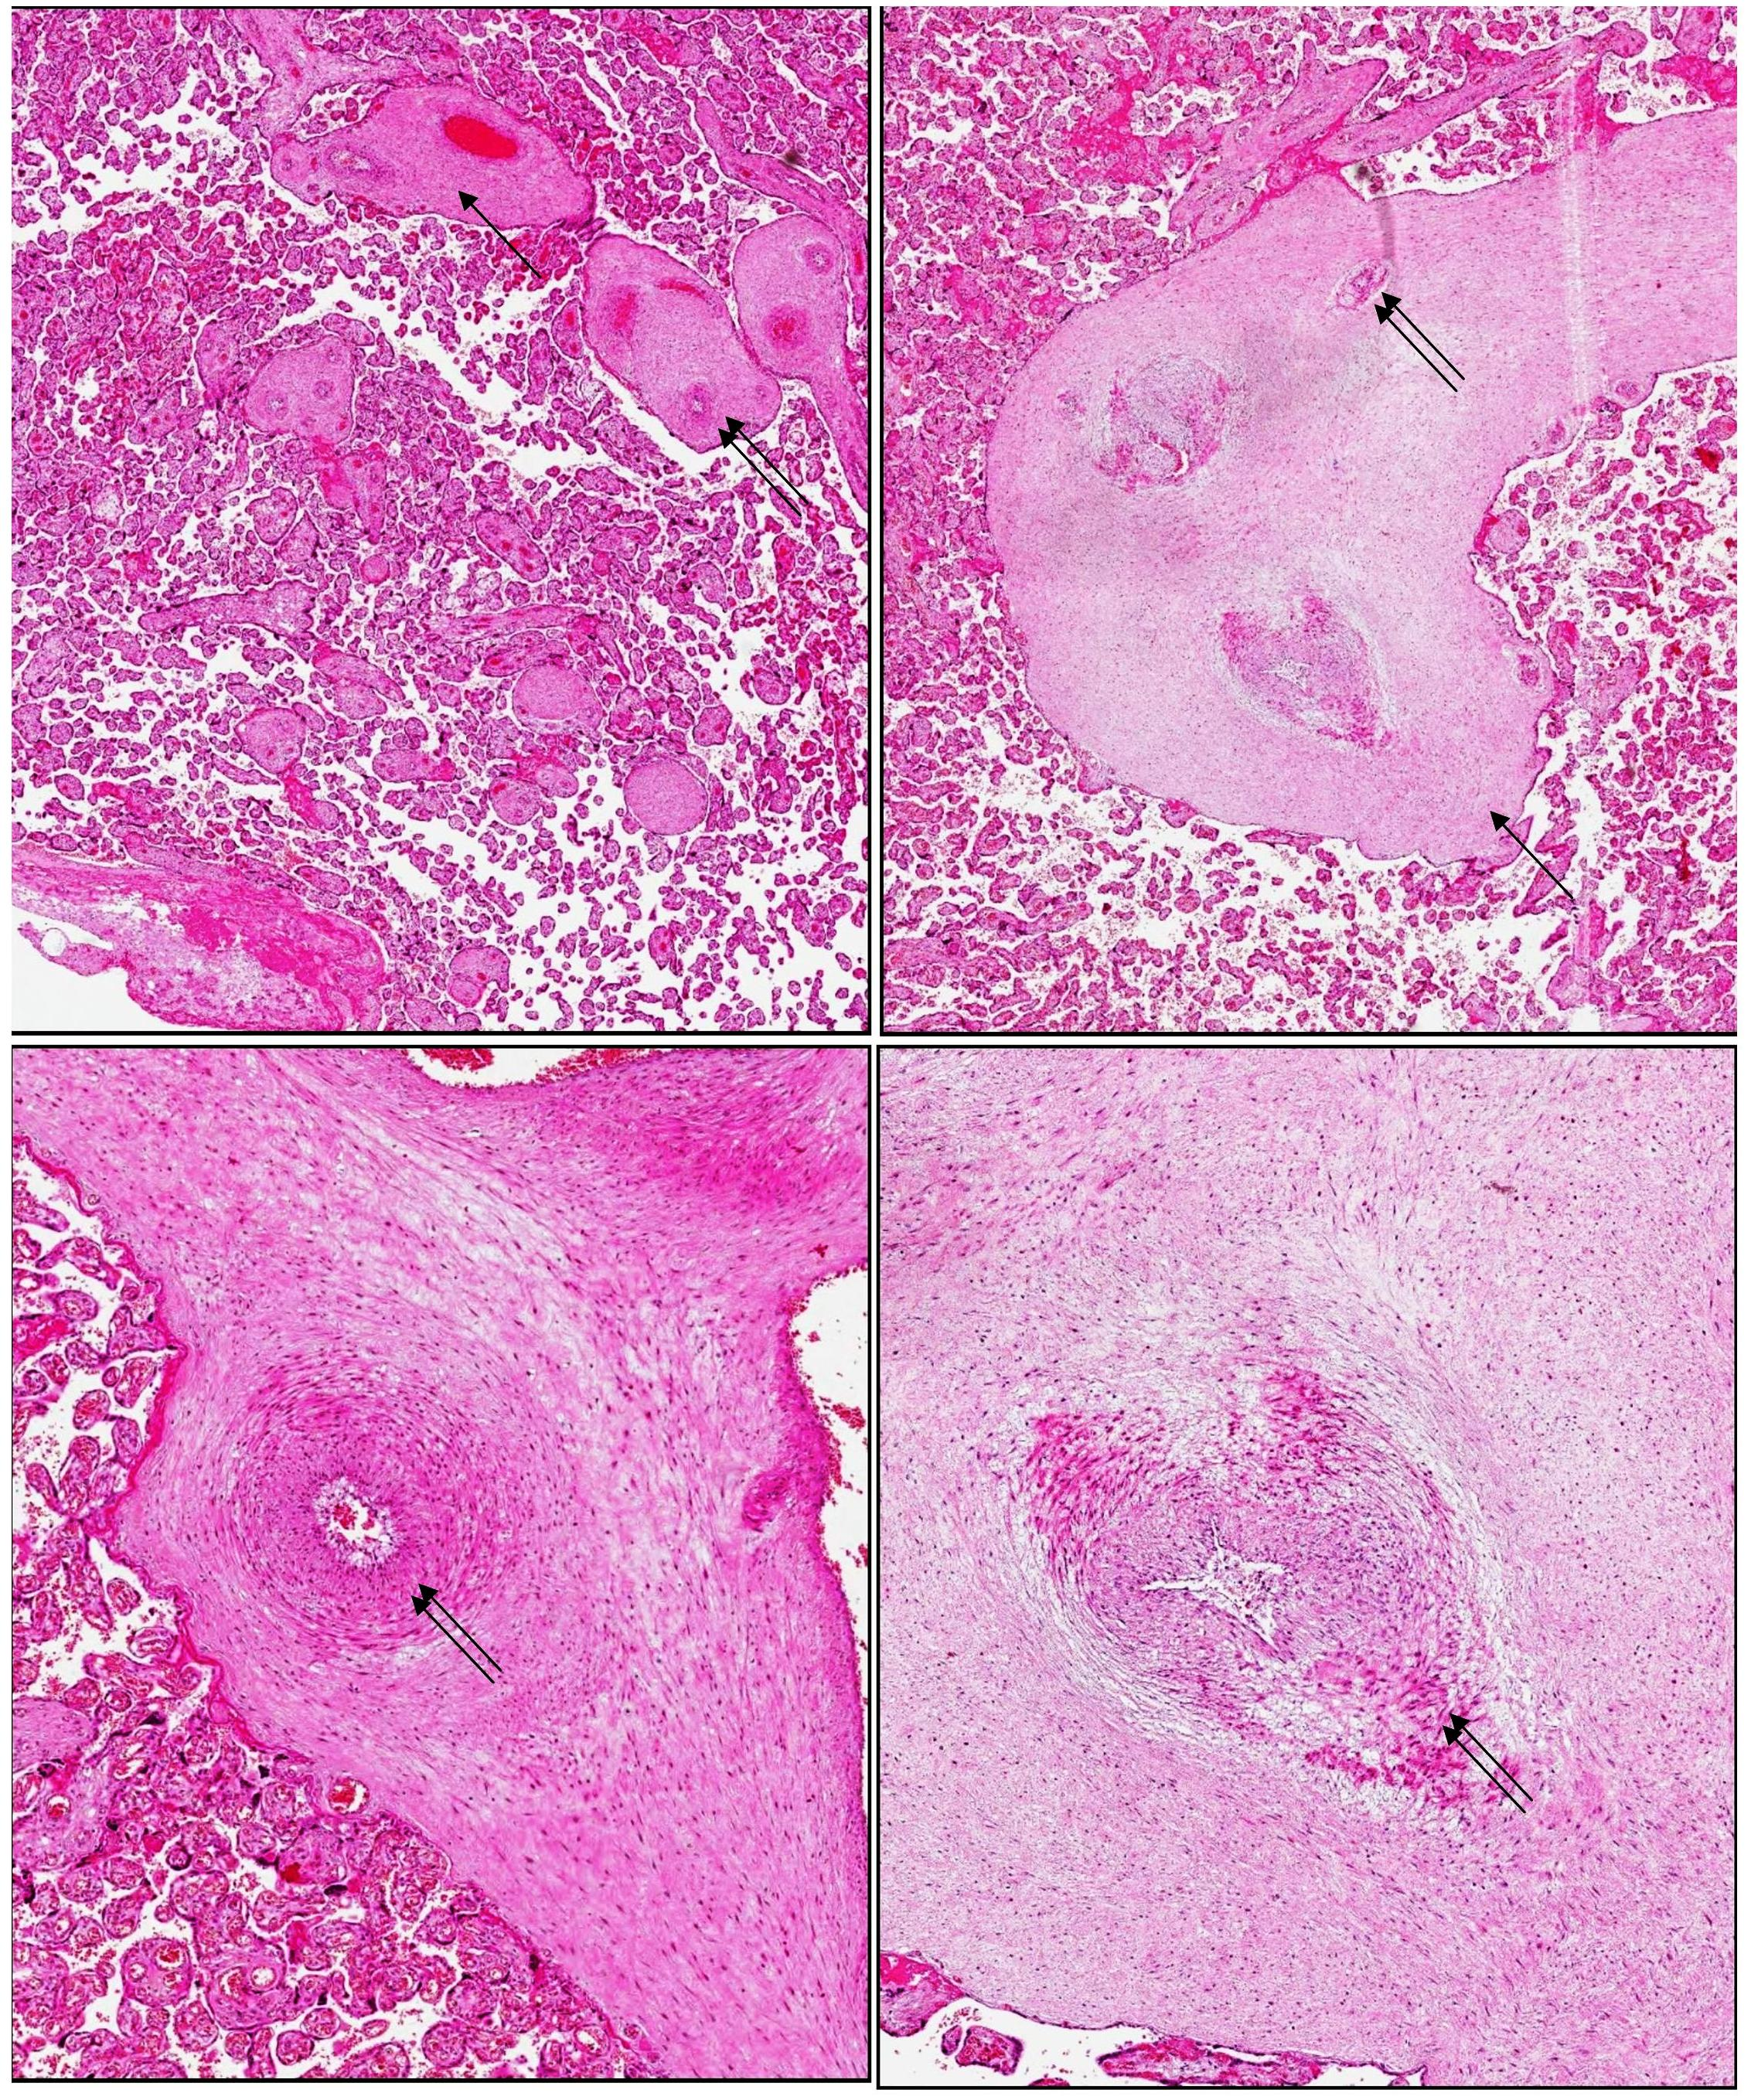

In [2]:
from IPython.display import Image
Image('/content/Histopathologic-Breast-Cancer-Detection/image1.jpg', width=200, height=200)

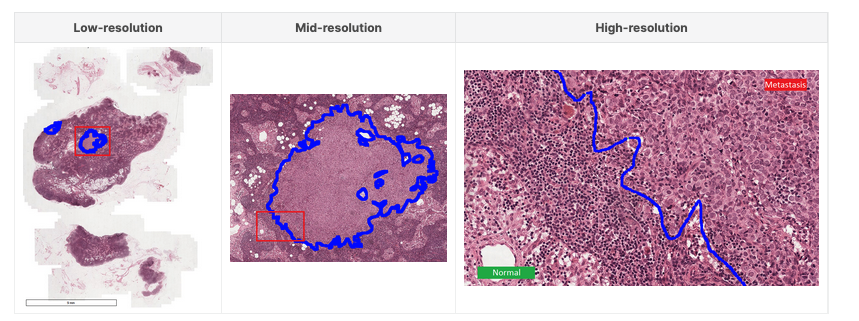

In [3]:
from IPython.display import Image
Image('/content/Histopathologic-Breast-Cancer-Detection/image2.png', width=200, height=200)

In [4]:
!gdown https://drive.google.com/uc?id=1BK7RVm8BYajRkmsiZWTGJ7tWozC3bNU_

import zipfile
with zipfile.ZipFile("breast-histopathology-images.zip","r") as zip_ref:
    zip_ref.extractall("breast-histopathology-images")

Downloading...
From: https://drive.google.com/uc?id=1BK7RVm8BYajRkmsiZWTGJ7tWozC3bNU_
To: /content/breast-histopathology-images.zip
3.33GB [01:20, 41.4MB/s]


In [5]:
import pandas as pd
train= pd.read_csv('/content/Histopathologic-Breast-Cancer-Detection/data/data.csv')
train.head()

patient_id                                               path  target
0        9254  breast-histopathology-images/IDC_regular_ps50_...       0
1       12867  breast-histopathology-images/IDC_regular_ps50_...       1
2       12749  breast-histopathology-images/IDC_regular_ps50_...       0
3       16533  breast-histopathology-images/IDC_regular_ps50_...       0
4        9261  breast-histopathology-images/IDC_regular_ps50_...       0

In [6]:
len(train)

222019

In [7]:
from os import listdir
files = listdir("/content/breast-histopathology-images/")
print(len(files))

280


In [8]:
base_path = "/content/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

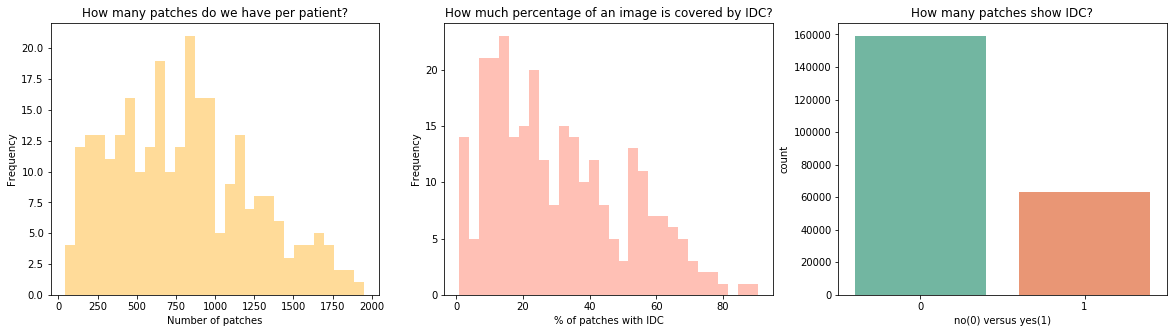

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cancer_perc = train.groupby("patient_id").target.value_counts()/ train.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(train.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(train.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

In [10]:
import numpy as np
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    base_path="breast-histopathology-images"
    path = base_path + "/"+ str(patient_id) + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df
example = get_patient_dataframe(train.patient_id.values[0])
example.head()

x     y  target                                               path
0  1801   401       0  breast-histopathology-images/9254/0/9254_idx5_...
1   751  1001       0  breast-histopathology-images/9254/0/9254_idx5_...
2   701  1151       0  breast-histopathology-images/9254/0/9254_idx5_...
3  3001  1551       0  breast-histopathology-images/9254/0/9254_idx5_...
4   401  1451       0  breast-histopathology-images/9254/0/9254_idx5_...

In [11]:
example.describe()

x            y       target
count  1172.000000  1172.000000  1172.000000
mean   1830.820819  1194.984642     0.147611
std     950.174267   461.807879     0.354865
min      51.000000    51.000000     0.000000
25%     951.000000   851.000000     0.000000
50%    1751.000000  1201.000000     0.000000
75%    2651.000000  1551.000000     0.000000
max    3451.000000  2501.000000     1.000000

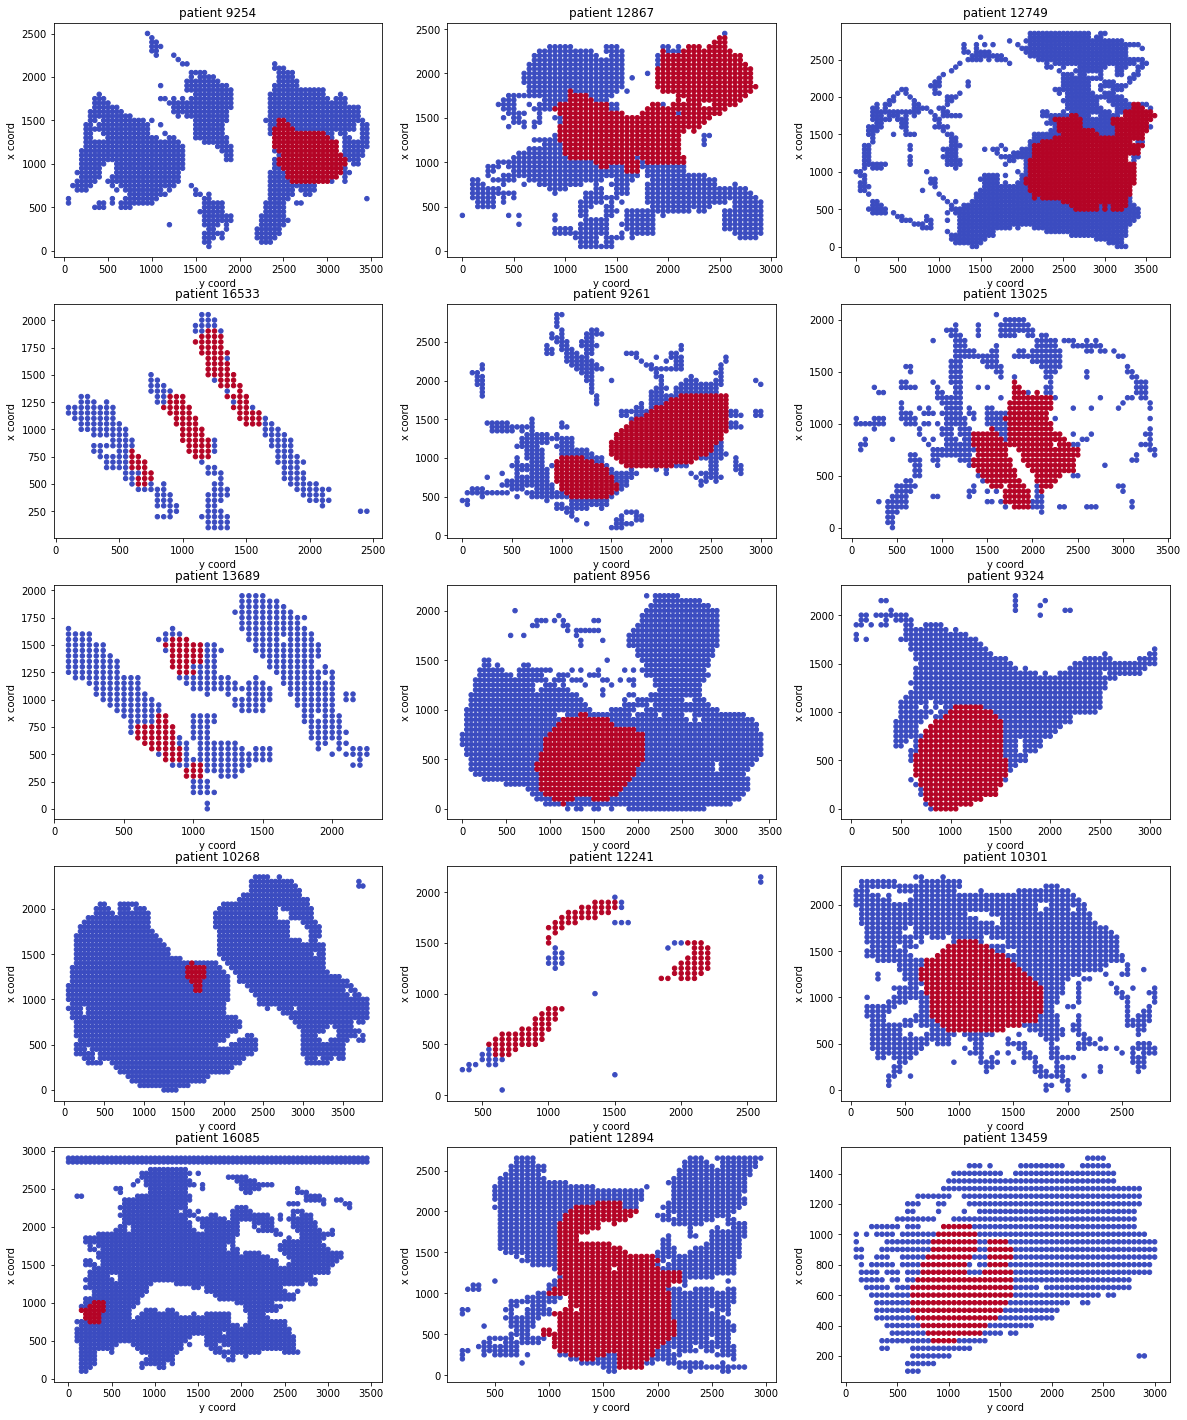

In [12]:
fig, ax = plt.subplots(5,3,figsize=(20, 25))

patient_ids = train.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + str(patient_id))
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

In [0]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        pred_df = pred_df.loc[pred_df.patient_id==patient_id].copy()
        mask_proba = np.zeros(shape = (example_df.y.max(), example_df.x.max())).astype(np.uint8)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 150
                mask[y_start:y_end, x_start:x_end, 1] = 150
                mask[y_start:y_end, x_start:x_end, 2] = 250
            if pred_df is not None:
                proba = pred_df[
                    (pred_df.x.astype(np.int)==x_coord) & (pred_df.y.astype(np.int)==y_coord)
                ].proba.values
                print(proba)
                mask_proba[y_start, x_start] = np.float(proba)
                print(mask_proba[y_start, x_start])

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    if pred_df is not None:
        return grid, mask, broken_patches, mask_proba
    else:
        return grid, mask, broken_patches

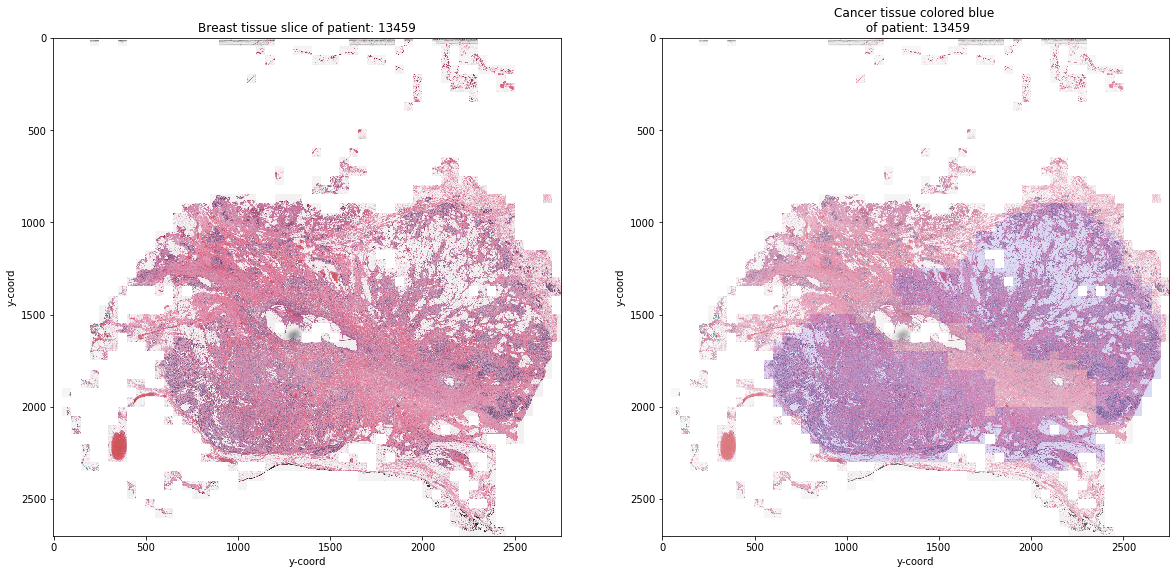

In [14]:
from skimage.io import imread
example = "13616"
grid, mask, broken_patches = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + str(patient_id))
ax[1].set_title("Cancer tissue colored blue \n of patient: " + str(patient_id));

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
def loading_data(path, f_name):
    
    X_data=[]
    y_data=[]
    data_path = os.path.join(path, '{}.csv'.format(f_name))
    data = pd.read_csv(data_path)
    
    X_id = data['path'].values
    Y = data['target'].values
    
    for file in X_id:
       
        img = cv2.imread(file)
        img =cv2.resize(img , (50, 50))
        X_data.append(img)                    
    
    return (np.array(X_data)/ 255.,np.array(Y))

In [0]:
X_train, y_train = loading_data("/content/Histopathologic-Breast-Cancer-Detection/data", 'train')

In [0]:
X_test, y_test = loading_data("/content/Histopathologic-Breast-Cancer-Detection/data", 'test')

In [18]:
import keras
y_train = keras.utils.to_categorical(y_train,2)
y_test = keras.utils.to_categorical(y_test,2)

Using TensorFlow backend.


In [0]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import mnist

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D 
from keras.optimizers import Adam, SGD, RMSprop

from keras.utils import np_utils 
from keras.callbacks import TensorBoard 
from keras import regularizers 
from time import time 

import matplotlib.pyplot as plt

In [0]:
np.random.seed(1671) # for reproducibility
# network and training

NB_EPOCH = 10 # number of epochs/episodes 
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION_SPLIT=0.1 # how much TRAIN is reserved for VALIDATION


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3
IMAGE_SIZE=50


In [21]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

          
        







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        18496     


In [22]:
from keras.callbacks import TensorBoard  
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
        
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)

history = model.fit(X_train,y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH,validation_split = VALIDATION_SPLIT,
          callbacks=[tensorboard_callback])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 72509 samples, validate on 8057 samples







Epoch 1/10
72509/72509 [==============================] - 37s 507us/step - loss: 0.5107 - acc: 0.7529 - val_loss: 0.4865 - val_acc: 0.7907

Epoch 2/10
72509/72509 [==============================] - 28s 388us/step - loss: 0.4379 - acc: 0.8080 - val_loss: 0.4331 - val_acc: 0.8169
Epoch 3/10
72509/72509 [==============================] - 28s 392us/step - loss: 0.4080 - acc: 0.8224 - val_loss: 0.4573 - val_acc: 0.7917
Epoch 4/10
72509/72509 [==============================] - 28s 392us/step - loss: 0.3966 - acc: 0.8291 - val_loss: 0.3942 - val_acc: 0.8302
Epoch 5/10
72509/72509 [==============================] - 28s 392us/step - loss: 0.3862 - acc: 0.8347 - val_loss: 0.3993 - val_acc: 0.8209
Epoch 6/10
72509/72509 [==============================] - 28s 389us/step - loss: 0.3782 - acc: 0.8400 - val_loss: 0.3866 - val_acc: 0.8339
Epoch 7/10

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


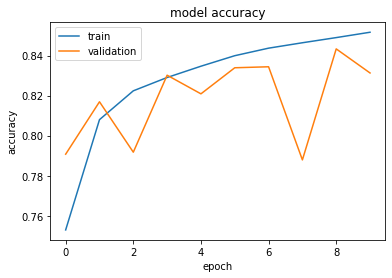

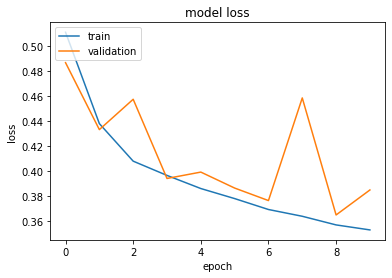

In [23]:
# tensorboard logs 
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
score = model.evaluate(X_test, y_test, verbose=VERBOSE,batch_size=BATCH_SIZE)
print("Test score:", score[0])
print('Test accuracy:', score[1])

20142/20142 [==============================] - 3s 144us/step
Test score: 0.38047144348720086
Test accuracy: 0.8376030185800029


In [0]:

train= pd.read_csv('/content/Histopathologic-Breast-Cancer-Detection/data/train.csv')


patient_ids = train.patient_id.unique()
patient_id = patient_ids[0]
example_df = get_patient_dataframe(patient_id)
        

In [0]:
y_pred=[]
for row in example_df.values:
  img = cv2.imread(row[-1])
  img =cv2.resize(img , (50, 50))/255.
  y_pred.append(np.argmax(model.predict(img.reshape(1,50,50,3))))

Text(0, 0.5, 'x coord')

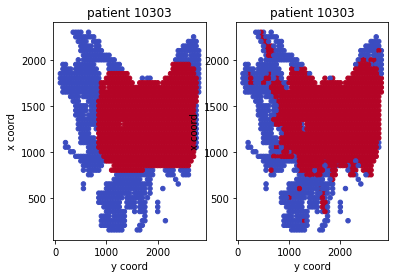

In [28]:
plt.subplot(1,2,1)
plt.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
plt.title("patient " + str(patient_id))
plt.xlabel("y coord")
plt.ylabel("x coord")
plt.subplot(1,2,2)
plt.scatter(example_df.x.values, example_df.y.values, c=y_pred, cmap="coolwarm", s=20);
plt.title("patient " + str(patient_id))
plt.xlabel("y coord")
plt.ylabel("x coord")

In [31]:
%%file /content/Histopathologic-Breast-Cancer-Detection/submissions/starting_kit/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Reshape
from keras.layers import Flatten
from keras.optimizers import SGD
from rampwf.workflows.image_classifier import get_nb_minibatches
from keras.layers import Conv2D, MaxPooling2D

import numpy as np


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import ImageDataGenerator
import cv2


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 128
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            # Total number of steps (batches of samples) to yield from
            # generator before declaring one epoch finished and starting the
            # next epoch. It should typically be equal to the number of unique
            # samples of your dataset divided by the batch size.
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=3,
            # In parallel to training, a CPU process loads and preprocesses
            # data from disk and put it into a queue in the form of
            # mini-batches of size `batch_size`.`max_queue_size` controls the
            # maximum size of that queue. The size of the queue should be big
            # enough so that the training process (GPU) never
            # waits for data (the queue should be never be empty).
            # The CPU process loads chunks of 1024 images each time, and
            # 1024/batch_size mini-batches from that chunk are put into the
            # queue. Assuming training the model on those 1024/batch_size
            # mini-batches is slower than loading a single chunk of 1024
            # images, a good lower bound for `max_queue_size` would be
            # (1024/batch_size). if `batch_size` is 16, you can put
            # `max_queue_size` to 64.
            max_queue_size=64,
            # WARNING : It is obligatory to set `workers` to 1.
            # This in principle controls the number of workers used
            # by keras to load mini-batches from disk to memory in parallel
            # to GPU training. But I don't like the way it works and their
            # code is not very commented/used, so I dont trust it that much
            # (we might have surprises).
            # The way it works in keras is by launching in parallel `workers`
            # threads or processes which will all use a copy of the generator
            # passed to `fit_generator`. So if nothing is done and `workers`
            # is set to some number > 1, the neural net will be trained with
            # repetitions of the same data, because the workers are independent
            # and they got through the same generator.
            # Hence it is necessary to introduce a shared lock between the the
            # processes so that they load different data, this can become a bit
            # complicated, so I choose to rather load exactly one chunk at a
            # time using 1 worker (so `workers` have to be equal to 1), but
            # do this single chunk loading in parallel with joblib.
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        kernel_size = (3,3)
        pool_size= (2,2)
        first_filters = 32
        second_filters = 64
        third_filters = 128

        dropout_conv = 0.3
        dropout_dense = 0.3
        IMAGE_SIZE=50

        model = Sequential()
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(dropout_dense))
        model.add(Dense(2, activation = "softmax"))
       
        model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        
        
        return model

Writing /content/Histopathologic-Breast-Cancer-Detection/submissions/starting_kit/batch_classifier.py


In [33]:
%%file /content/Histopathologic-Breast-Cancer-Detection/submissions/starting_kit/image_preprocessor.py
import cv2
def transform(x):   
        x = x / 255.
        x_resize = cv2.resize(x, (50,50))
        return x_resize

Writing /content/Histopathologic-Breast-Cancer-Detection/submissions/starting_kit/image_preprocessor.py


In [34]:
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow

  Cloning https://github.com/paris-saclay-cds/ramp-workflow to /tmp/pip-req-build-mu_es017
  Running command git clone -q https://github.com/paris-saclay-cds/ramp-workflow /tmp/pip-req-build-mu_es017
  Created wheel for ramp-workflow: filename=ramp_workflow-0.2.0+58.gc1b4273-cp36-none-any.whl size=2957723 sha256=f11f19c21878356e540867a5ff1a9220b989348e63135efbc886c1c366485627
  Stored in directory: /tmp/pip-ephem-wheel-cache-ybi53lx2/wheels/35/a2/c3/7969a73ddfefc0dcad3709cb7a81f52fb90348df9bb9b8c455
Successfully built ramp-workflow


In [35]:
!ramp_test_submission --quick-test

Traceback (most recent call last):
  File "/usr/local/bin/ramp_test_submission", line 8, in <module>
    sys.exit(ramp_test_submission())
  File "/usr/local/lib/python3.6/dist-packages/rampwf/utils/command_line.py", line 104, in ramp_test_submission
    retrain=retrain)
  File "/usr/local/lib/python3.6/dist-packages/rampwf/utils/testing.py", line 88, in assert_submission
    problem = assert_read_problem(ramp_kit_dir)
  File "/usr/local/lib/python3.6/dist-packages/rampwf/utils/testing.py", line 32, in assert_read_problem
    os.path.join(ramp_kit_dir, 'problem.py'))
  File "/usr/lib/python3.6/imp.py", line 172, in load_source
    module = _load(spec)
  File "<frozen importlib._bootstrap>", line 684, in _load
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 780, in get_code
  File "/usr/lib/python3.6/imp.py", line 158, in get_data
    return 